In [1]:
#Ignore warnings
import warnings
warnings.filterwarnings("ignore")

import math
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

import scipy.stats as stats

import matplotlib.pyplot as plt 
import seaborn as sns

import wrangle as wr

---

# Acquire Data:

In [2]:
train, validate, test = wr.wrangle_zillow()

In [3]:
train.shape, validate.shape, test.shape

((40064, 34), (17171, 34), (14309, 34))

In [4]:
train.head()

,id,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,...,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transactiondate,heatingorsystemdesc,propertylandusedesc
62924,2806823,11317340,2.0,4.0,6.0,2.0,1860.0,1860.0,6037.0,2.0,...,127127.0,157578.0,2016.0,30451.0,2755.87,6.037901e+13,0.030870,2017-08-01,Central,Single Family Residential
2686,2192094,12965175,4.0,3.0,8.0,4.0,1910.0,1910.0,6037.0,4.0,...,253705.0,667918.0,2016.0,414213.0,8704.21,6.037621e+13,0.021421,2017-01-12,Central,Condominium
35780,64334,11703478,1.0,3.0,6.0,1.0,1822.0,1822.0,6037.0,1.0,...,17787.0,40542.0,2016.0,22755.0,627.91,6.037232e+13,-0.325563,2017-05-12,Central,Single Family Residential
14782,1744938,10931831,3.0,2.0,8.0,3.0,1480.0,1480.0,6037.0,3.0,...,200660.0,473304.0,2016.0,272644.0,5682.71,6.037143e+13,0.009975,2017-03-06,Central,Condominium
27632,1643700,11181835,2.0,3.0,4.0,2.0,1370.0,1370.0,6037.0,2.0,...,43628.0,66954.0,2016.0,23326.0,918.71,6.037910e+13,0.010471,2017-04-19,Central,Single Family Residential


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40064 entries, 62924 to 59940
Data columns (total 34 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            40064 non-null  int64  
 1   parcelid                      40064 non-null  int64  
 2   bathroomcnt                   40064 non-null  float64
 3   bedroomcnt                    40064 non-null  float64
 4   buildingqualitytypeid         24997 non-null  float64
 5   calculatedbathnbr             40064 non-null  float64
 6   calculatedfinishedsquarefeet  40064 non-null  float64
 7   finishedsquarefeet12          40064 non-null  float64
 8   fips                          40064 non-null  float64
 9   fullbathcnt                   40064 non-null  float64
 10  heatingorsystemtypeid         25964 non-null  float64
 11  latitude                      40064 non-null  float64
 12  longitude                     40064 non-null  float64
 1

In [5]:
# verifying single unit property land types
train.propertylandusedesc.value_counts()

Single Family Residential    29312
Condominium                  10715
Mobile Home                     34
Townhouse                        3
Name: propertylandusedesc, dtype: int64

# Exercises

Sourcing the Zillow database as the data source, create a jupyter notebook named explore_zillow and do the following:

#### Ask at least 5 questions about the data, keeping in mind that your target variable is logerror. 
- e.g. Is logerror significantly different for properties in LA County vs Orange County vs Ventura County?

### Questions :
- Is log error significantly different per number of bathrooms?
- Is log error significantly different per number of bedrooms?
- Is log error significantly different per average sqaure feet in LA vs Orange vs Ventura? 
- Is log error significantly different per age of a home? 
- Is log error significantly different depending on the type of property. 

To answer these questions, I will make a dataframe from train that only contains the neccessary columns.

In [40]:
# select columns for that may be able to answer these specific
# set of questions
logerror_df = train[['parcelid','logerror', 'bathroomcnt',
                     'bedroomcnt', 'calculatedfinishedsquarefeet',
                     'fips', 'yearbuilt', 'propertylandusedesc']]

In [41]:
# pre-tidy
logerror_df.head()

,parcelid,logerror,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,yearbuilt,propertylandusedesc
62924,11317340,0.030870,2.0,4.0,1860.0,6037.0,1998.0,Single Family Residential
2686,12965175,0.021421,4.0,3.0,1910.0,6037.0,2014.0,Condominium
35780,11703478,-0.325563,1.0,3.0,1822.0,6037.0,1912.0,Single Family Residential
14782,10931831,0.009975,3.0,2.0,1480.0,6037.0,2010.0,Condominium
27632,11181835,0.010471,2.0,3.0,1370.0,6037.0,1954.0,Single Family Residential


In [42]:
# Tidy the dataframe a bit
logerror_df = logerror_df.rename(columns={'bathroomcnt':'bathrooms', 
                                          'bedroomcnt':'bedrooms',
                                          'calculatedfinishedsquarefeet':'sqaure_feet',
                                          'fips':'county', 'yearbuilt':'year_built', 
                                          'propertylandusedesc':'property_type'})


county = {6037:'Los Angeles', 6059:'Orange', 6111:'Ventura'}
logerror_df.county = logerror_df.county.map(county)

logerror_df.bedrooms = logerror_df.bedrooms.astype(int)
logerror_df.bathrooms = logerror_df.bathrooms.astype(int)
logerror_df.sqaure_feet = logerror_df.sqaure_feet.astype(int)
logerror_df.year_built = logerror_df.year_built.astype(int)

In [43]:
# post-tidy
logerror_df.head()

,parcelid,logerror,bathrooms,bedrooms,sqaure_feet,county,year_built,property_type
62924,11317340,0.030870,2,4,1860,Los Angeles,1998,Single Family Residential
2686,12965175,0.021421,4,3,1910,Los Angeles,2014,Condominium
35780,11703478,-0.325563,1,3,1822,Los Angeles,1912,Single Family Residential
14782,10931831,0.009975,3,2,1480,Los Angeles,2010,Condominium
27632,11181835,0.010471,2,3,1370,Los Angeles,1954,Single Family Residential


---

### Distribution of dataframe

<Figure size 720x576 with 0 Axes>

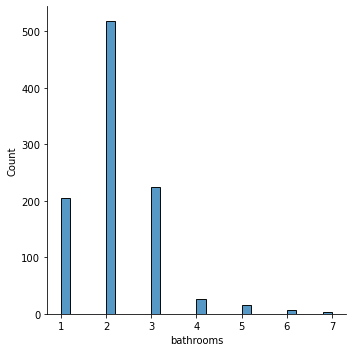

<Figure size 720x576 with 0 Axes>

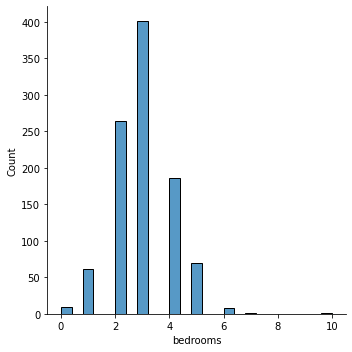

<Figure size 720x576 with 0 Axes>

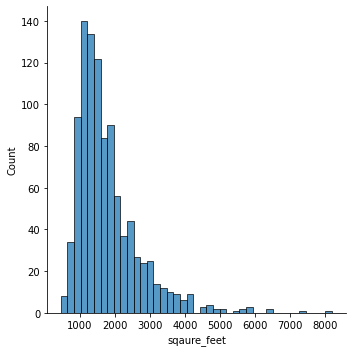

<Figure size 720x576 with 0 Axes>

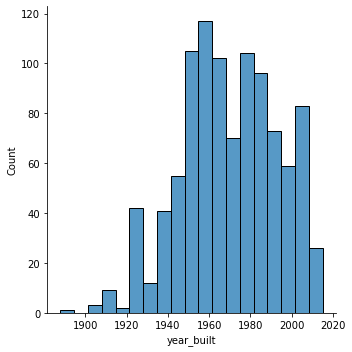

<Figure size 720x576 with 0 Axes>

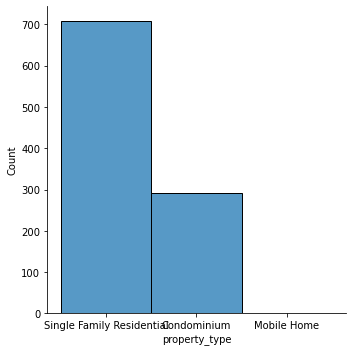

<Figure size 720x576 with 0 Axes>

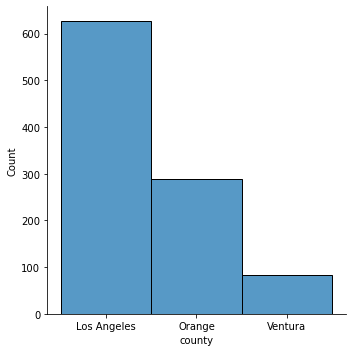

In [45]:
columns = ['bathrooms','bedrooms', 'sqaure_feet', 'year_built',
           'property_type', 'county' ]

for col in columns:
    plt.figure(figsize=(10,8))
    sns.displot(data=logerror_df.sample(1000), x=col)

---

### Is log error significantly different per number of bathrooms?